# Pedestrian Travel Isochrones: Visualizing the 20-Minute Neighborhood

In [1]:
%load_ext watermark
%watermark -a 'eli knaap' -v -d -u -p geopandas,geosnap

/Users/knaaptime/Dropbox/projects/geosnap/geosnap/_data.py:66: UserWarning: The geosnap data storage class is provided for convenience only. The geosnap developers make no promises regarding data quality, consistency, or availability, nor are they responsible for any use/misuse of the data. The end-user is responsible for any and all analyses or applications created with the package.
  warn(


Author: eli knaap

Last updated: 2022-06-23

Python implementation: CPython
Python version       : 3.9.10
IPython version      : 8.2.0

geopandas: 0.10.2
geosnap  : 0.10.0+6.g592f2ee57e05.dirty



As a package focused on "neighborhoods", much of the functionality in geosnap is organized around the concept of 'endogenous' neighborhoods. That is, it takes a classical perspective on neighborhood formation: a 'neighborhood' is defined loosely by its social composition, and the dynamics of residential mobility mean that these neighborhoods can grow, shrink, or transition entirely. 

But two alternative concepts of "neighborhood" are also worth considering. The first, posited by social scientists, is that each person or household can be conceptialized as residing in *its own* neighborhood which extends outward from the person's household until some threshold distance. This neighborhood represents the boundary inside which we might expect some social interaction to occur with one's 'neighbors'. The second is a normative concept advocated by architects, urban designers, and planners (arguably still the goal for [new urbanists](http://www.newurbanism.org)): that a neighborhood is [a discrete pocket of infrastructure](https://en.wikipedia.org/wiki/Neighbourhood_unit) organized as a small, self-contained economic unit. A common shorthand today is [the 20 minute neighborhood](https://linkinghub.elsevier.com/retrieve/pii/S1361920921004077). 

![](https://upload.wikimedia.org/wikipedia/en/e/e3/New_York_Regional_Survey%2C_Vol_7.jpg?20170410025533)

<https://upload.wikimedia.org/wikipedia/en/e/e3/New_York_Regional_Survey%2C_Vol_7.jpg?20170410025533>

The difference between these two perspectives is really what defines the origin of the neighborhood (the 'town center' or the person's home), and whether 'neighborhood' is universal to all neighbors or unique for each resident. Both of them rely abstractly on the concept of an isochrone: the set of destinations accessible within a specified travel budget. Defining an isochrone is a network routing problem, but its spatial representation is usually given as a polygon that covers the set of locations. That polygon is also sometimes called a walkshed (or *travel shed, depending on the particular mode). For the person at the center of the isochrone, whose "neighborhood" the isochrone represents, the polygon is sometimes conceptualized as an "egohood" or "bespoke neighborhood". 

The trouble with generating isochrones is twofold. First, they are computationally intensive to create. You need to know the shortest path from an origin to all other possible destinations inside the travel threshold, and depending on the density of the network, this can scale masssively. Second, they are not straightforward to present cartographically/visually. The set of destinations reachable within the threshold is technically a set of *points*. If you're constrained to a network, then we can usually assume that you also have access to potential locations between discrete destinations. For example if you're walking along the sidewalk, you can stop at any house along the block until you reach your threshold distance. But sometimes that's not the case. If you walk to a subway station, you can stop anywhere along the walk--until you get into the subway, then you are stuck traveling in one direction until you reach another station, then you get freedom of mobility again. 

The latter case is particularly difficult to represent because it doesnt create a "valid" polygon... there's a single polygon in the pre-transit zone, then the "accessible zone" collapses to a line (or nothing at all?) before opening back up into a polygon again. Like a barbell. If you take the simple route and just draw a [convex hull](https://en.wikipedia.org/wiki/Convex_hull) around the accessible destinations, it will fail to collapse along the line, giving the false impression of much more 'access' than is realistic.

But then again, sometimes these off-network spaces are actually traversable. If two network nodes inside the travel threshold are separated by a park, then you can just walk through the park and that should be included in the visualization. If they are separated by a harbor or a mountain, you definitely can't walk through (ok, maybe you could *get* through, but not without sacrificing a bit of speed at the very least).

To handle these issues, the isochrones implemented in geosnap take a straightforward approach, achieving a good balance between accuracy and speed. Specifically, we tackle the problem in two stages: first, we use pandana to generate the set nodes accessible from [a set of] destination[s]. Then we wrap an [alpha shape](https://en.wikipedia.org/wiki/Alpha_shape) around those destinations to create a tightly-fitted polygon. The alpha shape algorithm implemented in libpysal is also blazing fast, so the approach has worked quite well in all of our applications

In [2]:
from geosnap.analyze import compute_travel_cost_adjlist, isochrone, isochrones # a singular and a plural
from geosnap.io import get_acs
from geosnap import DataStore

In [3]:
import pandana as pdna
import geopandas as gpd

In [4]:
datasets = DataStore()

/Users/knaaptime/Dropbox/projects/geosnap/geosnap/_data.py:66: UserWarning: The geosnap data storage class is provided for convenience only. The geosnap developers make no promises regarding data quality, consistency, or availability, nor are they responsible for any use/misuse of the data. The end-user is responsible for any and all analyses or applications created with the package.
  warn(


To generate a routable network, use [pandana]() or [urbanaccess](). Alternatively, you can download one of the metropolitan-scale pedestrian networks for the U.S. from geosnap's [quilt bucket](https://open.quiltdata.com/b/spatial-ucr/tree/osm/metro_networks_8k/). The files are named for each CBSA fips code and extend 8km beyond the metro region's borders to help mitigate edge effects. Here, we'll use the quilt version from the San Diego region.

In [5]:
sd_network = pdna.Network.from_hdf5("../../geosnap_data/metro_networks_8k/41740.h5")

Generating contraction hierarchies with 10 threads.
Setting CH node vector of size 332554
Setting CH edge vector of size 522484
Range graph removed 143094 edges of 1044968
. 10% . 20% . 30% . 40% . 50% . 60% . 70% . 80% . 90% . 100%


To generate a travel isochrone, we have to specify an origin node on the network. For demonstration purposes, we can randomly select an origin from the network's `nodes_df` dataframe (or choose a pre-selected example). To get the nodes for a specific set of origins, you can use pandana's [`get_node_ids`](http://udst.github.io/pandana/network.html#pandana.network.Network.get_node_ids) function

In [6]:
from random import sample

In [7]:
random_origin = sample(sd_network.nodes_df.index.unique().tolist(),1)[0]

In [8]:
random_origin

5534356004

In [9]:
example_origin = 1985327805

[~~Nike~~](https://www.nike.com/a/how-long-does-it-take-to-walk-a-mile), er... [this study](https://jamanetwork.com/journals/jamanetworkopen/fullarticle/2752818) says that the average person walks about a mile in 20 minutes, so we can define the 20-minute neighborhood for a given household as the 1-mile walkshed from that house. To simplify the computation a little, we say that each house "exists" at it's nearest intersection

(this is the abstraction `pandana` typically uses to simplify the problem when using data from OpenStreetMap. There's nothing prohibiting you from creating an even more realistic version with nodes for each residence, as long as you're comfortable creating the [`Network`](https://udst.github.io/pandana/network.html))

In [10]:
%%time
iso = isochrone(example_origin, sd_network, threshold=1600 ) # network is expressed in meters

/Users/knaaptime/Dropbox/projects/geosnap/geosnap/analyze/network.py:42: UserWarning: Geometry is in a geographic CRS. Results from 'centroid' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.

  origins.centroid.x, origins.centroid.y
/Users/knaaptime/Dropbox/projects/geosnap/geosnap/analyze/network.py:42: UserWarning: Geometry is in a geographic CRS. Results from 'centroid' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.

  origins.centroid.x, origins.centroid.y
/Users/knaaptime/Dropbox/projects/geosnap/geosnap/analyze/network.py:45: UserWarning: Geometry is in a geographic CRS. Results from 'centroid' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.

  destinations.centroid.x, destinations.centroid.y
/Users/knaaptime/Dropbox/projects/geosnap/geosnap/analyze/network.py:45: UserWarning: Geometr

  0%|          | 0/1 [00:00<?, ?it/s]

CPU times: user 7.85 s, sys: 446 ms, total: 8.3 s
Wall time: 3.28 s


In [11]:
iso.explore()

We can also look at how the isochrone or bespoke neighborhood changes size and shape as we consider alternative travel thresholds. Because of the underlying network configuration, changing the threshold often results in some areas of the "neighborhood" changing more than others

In [12]:
%%time
iso_multiple = isochrone(example_origin, sd_network, threshold=[1600, 2400, 3200]  )

/Users/knaaptime/Dropbox/projects/geosnap/geosnap/analyze/network.py:42: UserWarning: Geometry is in a geographic CRS. Results from 'centroid' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.

  origins.centroid.x, origins.centroid.y
/Users/knaaptime/Dropbox/projects/geosnap/geosnap/analyze/network.py:42: UserWarning: Geometry is in a geographic CRS. Results from 'centroid' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.

  origins.centroid.x, origins.centroid.y
/Users/knaaptime/Dropbox/projects/geosnap/geosnap/analyze/network.py:45: UserWarning: Geometry is in a geographic CRS. Results from 'centroid' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.

  destinations.centroid.x, destinations.centroid.y
/Users/knaaptime/Dropbox/projects/geosnap/geosnap/analyze/network.py:45: UserWarning: Geometr

  0%|          | 0/1 [00:00<?, ?it/s]

CPU times: user 7.65 s, sys: 250 ms, total: 7.9 s
Wall time: 2.61 s


In [13]:
iso_multiple.explore('distance', cmap='Blues_r', style_kwds={'fillOpacity':0.5})

In this example it's easy to see how the road network topology makes it easier to travel in some directions more than others. Greenspace squeezes the western portion of the 1600m (20 min) isochrone into a horizontal pattern along Calle del Cerro, but the 2400m (30 minute) isochrone opens north-south tavel again along Avienda Pico, providing access to two other pockets of development, including San Clemente High School

We can also compare the network-based isochrone to the as-the-crow-flies approximation given by a euclidean buffer. If we didn't have access to network data, this would be our best estimate of the shape and extent of the 20-minute neighborhood.

In [14]:
# convert the node into a Point and buffer it 1600m

example_point = gpd.GeoDataFrame(sd_network.nodes_df.loc[example_origin]).T
example_point.crs=4326
planar_iso = example_point.to_crs(example_point.estimate_utm_crs()).buffer(1600)

In [15]:
# plot the buffer and isochrone on the same map

m = planar_iso.to_crs(4326).explore()
iso.explore(m=m)

Obviously from this depiction, network-constrained travel is very different from a euclidean approximation. That's especially true in places with irregular networks or topography considerations (like much of California)

## Isochrones for Specified Locations

the `isochrones` function calculates several isochrones simultaneously, given a set of input destinations. For example we could look at the 20-minute neighborhood for schools in San Diego county.

In [16]:
from geosnap.io import get_nces

In [17]:
isochrones?

Signature: isochrones(origins, threshold, network, matrix=None, network_crs=4326)
Docstring:
Create travel isochrones for several origins simultaneously

Parameters
----------
origins : geopandas.GeoDataFrame
    a geodataframe containing the locations of origin point features
network : pandana.Network
    pandana Network instance for calculating the shortest path isochrone for each origin feature
threshold: float
    maximum travel distance to define the isochrone, measured in the same units as edges_df
    in the pandana.Network object. If the network was created with pandana this is usually meters;
    if it was created with urbanaccess this is usually travel time in minutes.
matrix: pandas dataframe (optional)
    precalculated adjacency list dataframe created with `compute_travel_adjlist`
network_crs : str, int, pyproj.CRS (optional)
    the coordinate system used to store x and y coordinates in the passed pandana network.
    If the network was created with pandana or urbanaccess

In [18]:
# same as county fips 06073 in this case, but use metro fips for consistency with network
sd = get_acs(datasets, msa_fips='41740', level='bg', years=[2019])

<AxesSubplot:>

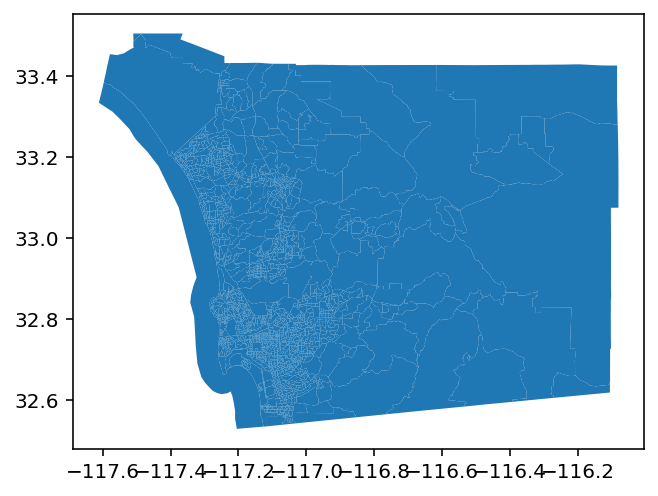

In [19]:
sd.plot()

In [20]:
schools = get_nces(datasets, dataset='schools')

In [21]:
sd_schools = schools[schools.to_crs(sd.crs).intersects(sd.unary_union)]

In [22]:
sd_schools.head()

,NCESSCH,NAME,OPSTFIPS,LSTREE,LCITY,LSTATE,LZIP,LZIP4,STFIP15,CNTY15,...,CBSATYPE15,CSA15,NMCSA15,NECTA15,NMNECTA15,CD15,SLDL15,SLDU15,geometry,year
5895,060004205341,Warner Junior/Senior High,06,30951 Highway 79,Warner Springs,CA,92086,M,06,06073,...,1,N,N,N,N,0650,071,038,POINT (-116.64292 33.27525),1516
5896,060004206527,San Jose Valley Continuation Hig,06,30951 Highway 79,Warner Springs,CA,92086,M,06,06073,...,1,N,N,N,N,0650,071,038,POINT (-116.64292 33.27525),1516
5897,060004206844,Warner Elementary,06,30951 Highway 79,Warner Springs,CA,92086,0008,06,06073,...,1,N,N,N,N,0650,071,038,POINT (-116.64292 33.27525),1516
5898,060004210387,All Tribes Charter,06,34320 Valley Center Rd.,Valley Center,CA,92082,6046,06,06073,...,1,N,N,N,N,0650,075,038,POINT (-116.95367 33.27796),1516
5899,060004212735,All Tribes Elementary Charter,06,34320 Valley Center Rd.,Valley Center,CA,92082,6046,06,06073,...,1,N,N,N,N,0650,075,038,POINT (-116.95367 33.27796),1516


<AxesSubplot:>

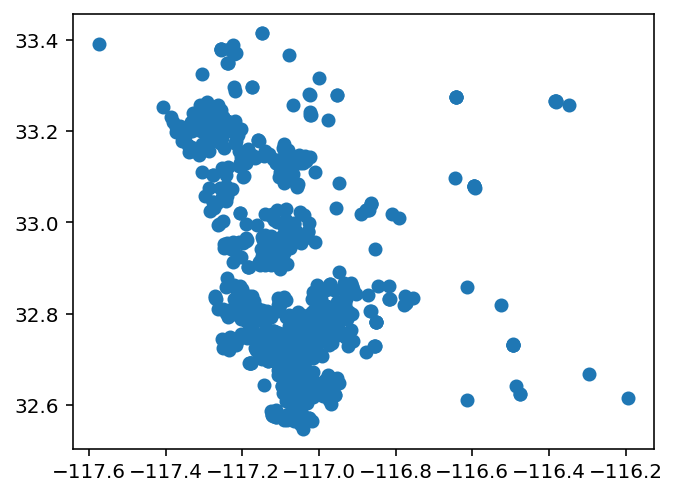

In [23]:
sd_schools.plot()

In [24]:
# randomly sample 25 schools and compute their walksheds

school_neighborhoods = isochrones(origins=sd_schools.sample(25), network=sd_network, threshold=1600,)

/Users/knaaptime/Dropbox/projects/geosnap/geosnap/analyze/network.py:42: UserWarning: Geometry is in a geographic CRS. Results from 'centroid' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.

  origins.centroid.x, origins.centroid.y
/Users/knaaptime/Dropbox/projects/geosnap/geosnap/analyze/network.py:42: UserWarning: Geometry is in a geographic CRS. Results from 'centroid' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.

  origins.centroid.x, origins.centroid.y
/Users/knaaptime/Dropbox/projects/geosnap/geosnap/analyze/network.py:45: UserWarning: Geometry is in a geographic CRS. Results from 'centroid' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.

  destinations.centroid.x, destinations.centroid.y
/Users/knaaptime/Dropbox/projects/geosnap/geosnap/analyze/network.py:45: UserWarning: Geometr

  0%|          | 0/25 [00:00<?, ?it/s]

In [25]:
school_neighborhoods.explore()

If we adopt the "neighborhood unit" perspective, it might be reasonable to put a school at the center of the neihborhood, as it would provide equitable access to all residents. In that case, these are your neighborhoods

## Network-Based Travel Cost Matrix

In some cases, the isochrone is less interesting than the interaction structure it implies; Often in social science research, the isochrone is an abstract representation of the concept of distance decay. Social interactions are are more frequent among people who are close to one another, and the frequency of those interactions decreases with distance (in the isochrone case, the 'neighborhood' is a discrete container, in others a decay function is applied inside the isochrone to allow for a "continuous neighborhood"). 

Thus, in some research contexts, the isochrone itself is less useful than capturing the shortest-path network distance from a set of origins to a set of destinations (this can later be used as a spatial weights matrix or an input to [accessibility](https://pysal.org/access) analysis). The [`pandana`]() library is fantastic at finding shortest-paths through large networks, but it's [designed](http://udst.github.io/pandana/futurework.html) primarily for creating network aggregation queries rather than generating the dense all-pairs travel cost matrix--that's what this function generates.

Unlike the `isochrone` and `isochrones` functions which compute the shortest network path from each input origin *to every destination node in the network*, the `compute_travel_cost_adjlist` function only computes paths between the specified origins and destinations, reducing the computational burden for large networks (i.e. `compute_travel_cost_adjlist` allows you to subset the *destination* set also) .

(Under the hood, the isochrone functions use `compute travel_cost_adjlist` function to compute the path between the set of origins and *all* destination nodes in the network (i.e. subsetting only the origins, not the destinations). If you want to generate isochrones *really* fast e.g. in a web application, or do repeated queries for some other project, it's possible to compute and store the dense the all-pairs shortest-cost travel matrix ahead of time. Note this is happening at the *intersection* level, so for a metro the size of san diego, this is a *massive* problem, even with pandana's speed... In that case, you can pass the precomputed matrix directly to the `isochrones` function

In [26]:
compute_travel_cost_adjlist?

Signature:
compute_travel_cost_adjlist(
    origins,
    destinations,
    network,
    index_orig=None,
    index_dest=None,
)
Docstring:
Generate travel cost adjacency list.

Parameters
----------
origins : geopandas.GeoDataFrame
    a geodataframe containing the locations of origin features
destinations : geopandas.GeoDataFrame
    a geodataframe containing the locations of destination features
network : pandana.Network
    pandana Network instance for calculating the shortest path between origins and destinations
index_orig : str, optional
    Column on the origins dataframe the defines unique units to be used as the origins id
    on the resulting dataframe. If not set, each unit will be assigned the index from its
    associated node_id on the network
index_dest : str, optional
    Column on the destinations dataframe the defines unique units to be used as the destinations id
    on the resulting dataframe. If not set, each unit will be assigned the index from its
    associated 


We can trim the problem down by passing a geodataframe of origins/destinations like blockgroups or tracts to make the problem a bit smaller ($n_{blockgroups}^2$ instead of $n_{intersections}^2$)

In [27]:
sd_adj = compute_travel_cost_adjlist(sd, sd, sd_network, index_dest='geoid', index_orig='geoid')

/Users/knaaptime/Dropbox/projects/geosnap/geosnap/analyze/network.py:42: UserWarning: Geometry is in a geographic CRS. Results from 'centroid' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.

  origins.centroid.x, origins.centroid.y
/Users/knaaptime/Dropbox/projects/geosnap/geosnap/analyze/network.py:42: UserWarning: Geometry is in a geographic CRS. Results from 'centroid' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.

  origins.centroid.x, origins.centroid.y
/Users/knaaptime/Dropbox/projects/geosnap/geosnap/analyze/network.py:45: UserWarning: Geometry is in a geographic CRS. Results from 'centroid' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.

  destinations.centroid.x, destinations.centroid.y
/Users/knaaptime/Dropbox/projects/geosnap/geosnap/analyze/network.py:45: UserWarning: Geometr

  0%|          | 0/1795 [00:00<?, ?it/s]

The `sd_adj` dataframe is an adjacency list representation of the shortest-path cost between each block-group centroid in San Diego county

In [28]:
sd_adj

,origin,destination,cost
0,060730001001,060730001001,0.000
1,060730001001,060730001002,987.566
2,060730001001,060730002011,1221.944
3,060730001001,060730002021,2208.548
4,060730001001,060730002022,1465.891
...,...,...,...
1790,060739901000,060730220002,40466.678
1791,060739901000,060730221001,23566.234
1792,060739901000,060730221002,21198.103
1793,060739901000,060730221003,18928.505


## Extensions

One nice thing about this implementation is that it's indifferent to the structure of the input network. It could be pedestrian-based (which is the most common), but you could also use [urbanaccess](https://github.com/UDST/urbanaccess) to create a multimodel network by combining OSM and GTFS data.

Running the above functions on that multimodal network would give a good sense of "baseline" accessibility in a study region. An interested researcher could then make some changes to the GTFS network, say, by increasing bus frequency along a given corridor, then create another combined network and compare results. Who would benefit from such a change, and what might be the net costs?

And thus, the seeds of **open** and **reproducible** [scenario planning](https://www.tandfonline.com/doi/full/10.1080/01944363.2020.1746688) have been sown :)